In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import random
from collections import Counter

In [128]:
df = pd.read_excel("C:/Users/tikib/OneDrive/Documents/New_data_science_dataset.xlsx")

In [130]:
df

,customer_id,is_engager,receipt_id,receipt_item_id,brand_name,primary_category_name,secondary_category_name,tertiary_category_name,quantity,price,created_at
0,779512,Yes,123438217,2319081138,brand1,Dairy,Cheese,Cheese,1.0,2.29,2016-12-23 23:22:00
1,779513,Yes,101714769,1929715715,brand2,Dairy,Cheese,Cheese,1.0,1.99,2016-09-24 00:20:00
2,779513,Yes,119402577,2248090809,brand3,Beverages,Powdered Drinks & Mixes,Powdered Drinks & Mixes,1.0,0.00,2016-12-08 22:24:00
3,779513,Yes,104246626,1976136372,brand4,Grains & Pasta,Rice,Rice,1.0,2.19,2016-10-05 22:36:00
4,779514,Yes,121602854,2286703871,brand5,Dairy,Cheese,Cheese,1.0,4.49,2016-12-17 02:35:00
...,...,...,...,...,...,...,...,...,...,...,...
240552,780417,Yes,114511103,2157374051,brand29,Produce,Fruits,Tomatoes,1.0,NaN,2016-11-18 21:41:00
240553,779574,Yes,102025640,1935418160,brand203,Boxed Meals,Instant Meals,Instant Meals,1.0,NaN,2016-09-25 17:01:00
240554,779574,Yes,102025640,1935298138,brand29,Produce,Fruits,Apple,1.0,NaN,2016-09-25 17:01:00
240555,781865,Yes,111211495,2099639611,brand29,Produce,Fruits,Banana,1.0,NaN,2016-11-04 05:22:00


In [131]:
def clean_data(df):
    # Remove duplicates
    df = df.drop_duplicates()

    # Remove rows with missing values
    df = df.dropna()

    # Indicate buy/return: positive price = buy, negative price = return
    df['transaction_type'] = df['price'].apply(lambda x: 'buy' if x > 0 else 'return')

    # Remove rows where price is zero
    df = df[df['price'] != 0]

    return df

In [132]:
df = clean_data(df) 

In [286]:
def build_customer_journey_graph_with_engager(df):
    G = nx.Graph()  # Use an undirected graph
    customer_status = {}

    for customer_id, customer_group in df.groupby('customer_id'):
        engager_any_yes = False
        for receipt_id, group in customer_group.groupby('receipt_id'):
            journey = group.sort_values('primary_category_name')  # Sort by category just for consistency
            node_ids = []
            for idx, row in journey.iterrows():
                primary_category = row['primary_category_name'] if pd.notna(row['primary_category_name']) else "Unknown"
                if primary_category in ["No Info", "Unknown", ""]:
                    continue
                secondary_category = row['secondary_category'] if pd.notna(row.get('secondary_category', None)) else None
                brand_name = row['brand_name'] if pd.notna(row.get('brand_name', None)) else None

                node_id = f"{customer_id}_{receipt_id}_{primary_category}"
                G.add_node(
                    node_id,
                    primary_category_name=primary_category,
                    price=row['price'],
                    quantity=row['quantity'],
                    secondary_category=secondary_category,
                    brand_name=brand_name,
                    customer_id=customer_id,
                    receipt_id=receipt_id,
                    transaction_type=row['transaction_type'],
                )
                node_ids.append(node_id)
            # Add edges between all pairs of items (primary_category_name) in the same receipt, with edge weights as counts
            for i in range(len(node_ids)):
                for j in range(i + 1, len(node_ids)):
                    u, v = node_ids[i], node_ids[j]
                    if G.has_edge(u, v):
                        G[u][v]['weight'] += 1
                    else:
                        G.add_edge(u, v, weight=1)
            # Add final engager node as "engager_yes" or "engager_no" (general, not customer/receipt specific)
            if 'is_engager' in journey.columns:
                engager_value = journey.iloc[-1]['is_engager']
                if pd.isna(engager_value):
                    engager_value = "no"
                else:
                    engager_value = str(engager_value).strip().lower()
                if engager_value == "yes":
                    engager_any_yes = True
                    engager_node = "engager_yes"
                    G.add_node(engager_node, engager="yes")
                else:
                    engager_node = "engager_no"
                    G.add_node(engager_node, engager="no")
                # Connect all nodes in this receipt to the engager node, with edge weight as count
                for node_id in node_ids:
                    if G.has_edge(node_id, engager_node):
                        G[node_id][engager_node]['weight'] += 1
                    else:
                        G.add_edge(node_id, engager_node, weight=1)
        customer_status[customer_id] = "yes" if engager_any_yes else "no"

    for n, data in G.nodes(data=True):
        cust_id = data.get('customer_id')
        if cust_id in customer_status:
            G.nodes[n]['customer_engager_status'] = customer_status[cust_id]

    return G, customer_status

In [287]:
G, customer_status = build_customer_journey_graph_with_engager(df)

In [288]:
def plot_engager_vs_nonengager(G, n_customers=3):
    # Get customer_ids by engager status
    engager_yes = [cid for cid, status in set((d['customer_id'], d.get('customer_engager_status')) for n, d in G.nodes(data=True) if d.get('customer_id') is not None) if status == 'yes']
    engager_no = [cid for cid, status in set((d['customer_id'], d.get('customer_engager_status')) for n, d in G.nodes(data=True) if d.get('customer_id') is not None) if status == 'no']

    # Sample customers
    sampled_yes = random.sample(engager_yes, min(n_customers, len(engager_yes)))
    sampled_no = random.sample(engager_no, min(n_customers, len(engager_no)))

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    for ax, sampled, title in zip(axes, [sampled_yes, sampled_no], ["Engager: Yes", "Engager: No"]):
        # Collect nodes for sampled customers, ignore general engager nodes
        sampled_nodes = [n for n, data in G.nodes(data=True)
                         if data.get('customer_id') in sampled and not n.startswith('engager_')]
        # Also include the general engager node if it is connected to any sampled node
        engager_nodes = set()
        for n in sampled_nodes:
            for neighbor in G.neighbors(n):
                if neighbor in ("engager_yes", "engager_no"):
                    engager_nodes.add(neighbor)
        all_nodes = sampled_nodes + list(engager_nodes)
        H = G.subgraph(all_nodes).copy()
        if len(H) == 0:
            ax.set_title(f"No data for {title}")
            ax.axis('off')
            continue
        pos = nx.spring_layout(H, k=0.5, iterations=50, seed=42)
        node_labels = {n: H.nodes[n].get('primary_category_name', n) for n in H.nodes}
        # Label engager nodes clearly
        for n in engager_nodes:
            node_labels[n] = n.replace("engager_", "Engager: ").capitalize()
        nx.draw_networkx_nodes(H, pos, node_size=500, node_color='lightblue', ax=ax)
        
        # Edge weights for thickness, control for outliers
        weights = [H[u][v].get('weight', 1) for u, v in H.edges]
        # Use percentiles to clip outliers
        min_w = np.percentile(weights, 5) if len(weights) > 0 else 1
        max_w = np.percentile(weights, 95) if len(weights) > 0 else 1
        # Normalize and scale for linewidths
        norm_weights = [
            1 + 6 * (min(max(w, min_w), max_w) - min_w) / (max_w - min_w) if max_w > min_w else 2
            for w in weights
        ]
        nx.draw_networkx_edges(H, pos, width=norm_weights, ax=ax)
        nx.draw_networkx_labels(H, pos, labels=node_labels, font_size=8, ax=ax)
        ax.set_title(f"{title} (n={len(sampled)})")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

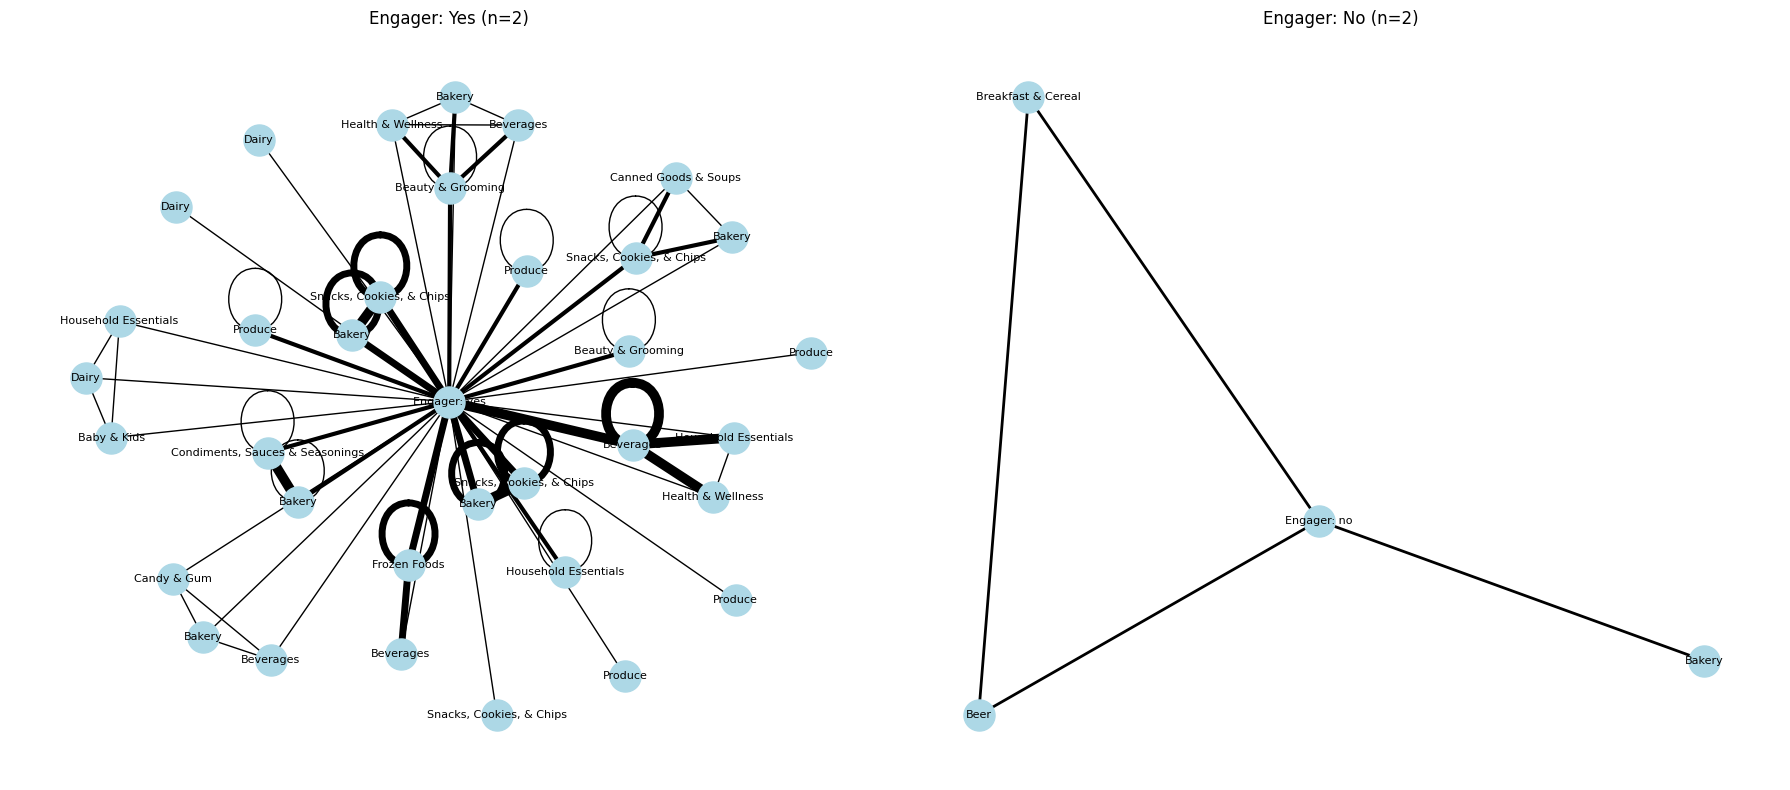

In [289]:
plot_engager_vs_nonengager(G, 2)

In [290]:
import igraph as ig

def nx_to_igraph(G):
    # Exclude engager nodes
    nodes = [n for n in G.nodes if not str(n).startswith("engager_")]
    mapping = {n: i for i, n in enumerate(nodes)}
    # Only take u and v for undirected graph, and only if both are not engager nodes
    edges = [(mapping[u], mapping[v]) for u, v in G.edges if u in mapping and v in mapping]
    weights = [G[u][v].get('weight', 1) for u, v in G.edges if u in mapping and v in mapping]
    g = ig.Graph(edges=edges, directed=False)
    g.es['weight'] = weights
    return g, mapping

def igraph_closeness_centrality(G):
    g, mapping = nx_to_igraph(G)
    # Use weights as distances (inverse of weight for "distance")
    # If higher weight means closer, use 1/weight as distance
    distances = [1/w if w > 0 else 1 for w in g.es['weight']]
    closeness = g.closeness(weights=distances)
    reverse_mapping = {v: k for k, v in mapping.items()}
    return {reverse_mapping[i]: c for i, c in enumerate(closeness)}

def add_centrality_metrics(G, betweenness_k=500):
    nodes = [n for n in G.nodes if not str(n).startswith("engager_")]
    subG = G.subgraph(nodes)
    degree_centrality = nx.degree_centrality(subG)
    # Use weights for betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(subG, k=min(betweenness_k, len(subG)), weight='weight')
    closeness_centrality = igraph_closeness_centrality(subG)

    for n in subG.nodes:
        G.nodes[n]['degree_centrality'] = degree_centrality.get(n, 0)
        G.nodes[n]['betweenness_centrality'] = betweenness_centrality.get(n, 0)
        G.nodes[n]['closeness_centrality'] = closeness_centrality.get(n, 0)
    for n in G.nodes:
        if str(n).startswith("engager_"):
            G.nodes[n]['degree_centrality'] = 0
            G.nodes[n]['betweenness_centrality'] = 0
            G.nodes[n]['closeness_centrality'] = 0


In [291]:
add_centrality_metrics(G)

In [292]:
def create_journey_df_with_last_node_centrality(G, df):
    """
    For each journey, find the last node and extract its centrality metrics,
    along with basic journey features. Returns a new journey_df.
    """
    features = []
    for (customer_id, receipt_id), group in df.groupby(['customer_id', 'receipt_id']):
        last_row = group.iloc[-1]
        primary_category = last_row['primary_category_name'] if pd.notna(last_row['primary_category_name']) else "Unknown"
        if primary_category in ["No Info", "Unknown", ""]:
            continue
        node_id = f"{customer_id}_{receipt_id}_{primary_category}_{last_row['created_at']}"
        node_data = G.nodes.get(node_id, {})
        is_engager = str(last_row['is_engager']).strip().lower() == "yes"
        # Median and std for buys and returns
        buys = group[group['transaction_type'] == 'buy']['price']
        returns = group[group['transaction_type'] == 'return']['price']
        median_buys = buys.median() if not buys.empty else 0
        std_buys = buys.std() if len(buys) > 1 else 0
        median_returns = returns.median() if not returns.empty else 0
        std_returns = returns.std() if len(returns) > 1 else 0
        features.append({
            'customer_id': customer_id,
            'receipt_id': receipt_id,
            'total_price': group['price'].sum(),
            'total_quantity': group['quantity'].sum(),
            'avg_price': group['price'].mean(),
            'avg_quantity': group['quantity'].mean(),
            'median_price': group['price'].median(),
            'median_quantity': group['quantity'].median(),
            'std_price': group['price'].std(),
            'std_quantity': group['quantity'].std(),
            'n_unique_categories': group['primary_category_name'].nunique(),
            'n_steps': len(group),
            'most_common_category': group['primary_category_name'].mode().iloc[0] if not group['primary_category_name'].mode().empty else "Unknown",
            'is_engager': int(is_engager),
            'n_buys': (group['transaction_type'] == 'buy').sum(),
            'n_returns': (group['transaction_type'] == 'return').sum(),
            'prop_buys': (group['transaction_type'] == 'buy').sum() / len(group) if len(group) > 0 else 0,
            'prop_returns': (group['transaction_type'] == 'return').sum() / len(group) if len(group) > 0 else 0,
            'median_buys': median_buys,
            'std_buys': std_buys,
            'median_returns': median_returns,
            'std_returns': std_returns,
            'degree_centrality': node_data.get('degree_centrality', 0),
            'betweenness_centrality': node_data.get('betweenness_centrality', 0),
            'closeness_centrality': node_data.get('closeness_centrality', 0)
        })
    journey_df = pd.DataFrame(features)
    return journey_df



In [293]:

journey_df = create_journey_df_with_last_node_centrality(G, df)

In [294]:
journey_df.columns

Index(['customer_id', 'receipt_id', 'total_price', 'total_quantity',
       'avg_price', 'avg_quantity', 'median_price', 'median_quantity',
       'std_price', 'std_quantity', 'n_unique_categories', 'n_steps',
       'most_common_category', 'is_engager', 'n_buys', 'n_returns',
       'prop_buys', 'prop_returns', 'median_buys', 'std_buys',
       'median_returns', 'std_returns', 'degree_centrality',
       'betweenness_centrality', 'closeness_centrality'],
      dtype='object')

In [297]:
def centrality_analysis(G):

    # Collect centrality metrics into a DataFrame
    data = []
    for n, d in G.nodes(data=True):
        if 'degree_centrality' in d:
            data.append({
                'degree_centrality': d['degree_centrality'],
                'betweenness_centrality': d['betweenness_centrality'],
                'closeness_centrality': d['closeness_centrality'],
                'engager': d.get('engager', None),
                'customer_engager_status': d.get('customer_engager_status', None),
                'transaction_type': d.get('transaction_type', None)
            })
    df_centrality = pd.DataFrame(data)

    print("Centrality metrics summary:\n", df_centrality.describe())

    # Plot distributions
    plt.figure(figsize=(15, 4))
    for i, col in enumerate(['degree_centrality', 'betweenness_centrality', 'closeness_centrality']):
        plt.subplot(1, 3, i+1)
        sns.histplot(df_centrality[col], kde=True)
        plt.title(f"{col} distribution")
    plt.tight_layout()
    plt.show()

    # Compare centrality by engager status if available
    if 'customer_engager_status' in df_centrality.columns:
        plt.figure(figsize=(10, 4))
        sns.boxplot(x='customer_engager_status', y='degree_centrality', data=df_centrality)
        plt.title("Degree Centrality by Engager Status")
        plt.show()

Centrality metrics summary:
        degree_centrality  betweenness_centrality  closeness_centrality
count       37419.000000            3.741900e+04          35382.000000
mean            0.000174            1.175913e-09              5.393730
std             0.000105            1.504872e-08              6.511716
min             0.000000            0.000000e+00              0.000000
25%             0.000080            0.000000e+00              2.000000
50%             0.000160            0.000000e+00              3.428571
75%             0.000241            0.000000e+00              6.486486
max             0.000508            1.389854e-06            167.888307


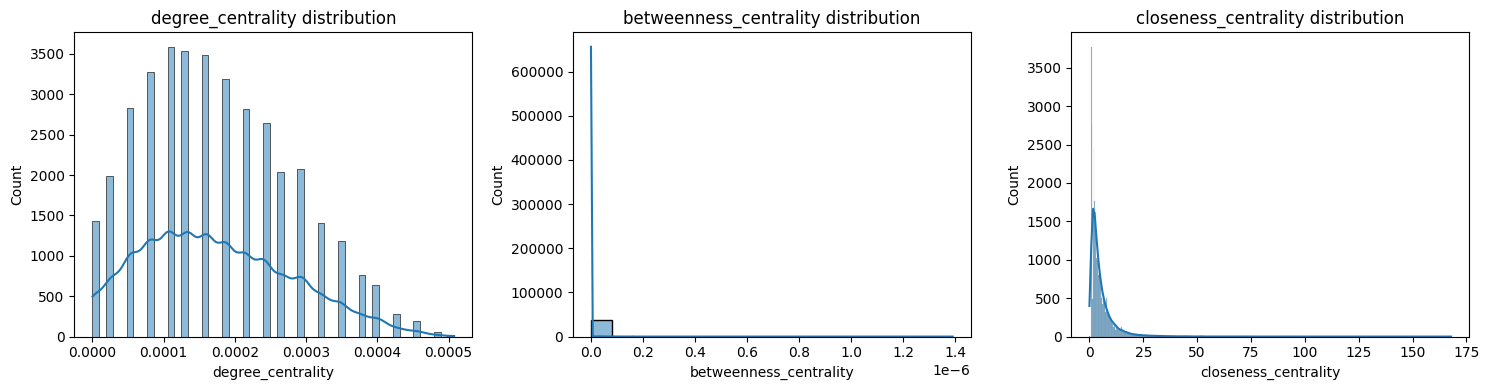

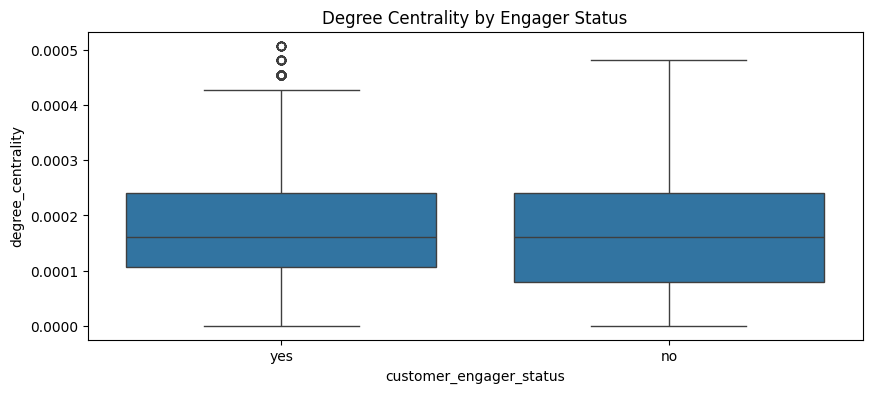

In [298]:
centrality_analysis(G)

In [299]:
def journey_centrality_features(G, df):
    features = []
    for (customer_id, receipt_id), group in df.groupby(['customer_id', 'receipt_id']):
        # No need to sort by 'created_at' for undirected graph and new node_id
        node_ids = []
        for idx, row in group.iterrows():
            primary_category = row['primary_category_name'] if pd.notna(row['primary_category_name']) else "Unknown"
            if primary_category in ["No Info", "Unknown", ""]:
                continue
            node_id = f"{customer_id}_{receipt_id}_{primary_category}"
            node_ids.append(node_id)
        # Get centrality values for all nodes in the journey
        deg = [G.nodes[n].get('degree_centrality', 0) for n in node_ids if n in G.nodes]
        bet = [G.nodes[n].get('betweenness_centrality', 0) for n in node_ids if n in G.nodes]
        clo = [G.nodes[n].get('closeness_centrality', 0) for n in node_ids if n in G.nodes]
        features.append({
            'customer_id': customer_id,
            'receipt_id': receipt_id,
            'journey_degree_centrality_mean': np.mean(deg) if deg else 0,
            'journey_degree_centrality_max': np.max(deg) if deg else 0,
            'journey_degree_centrality_median': np.median(deg) if deg else 0,
            'journey_degree_centrality_std': np.std(deg) if deg else 0,
            'journey_betweenness_centrality_mean': np.mean(bet) if bet else 0,
            'journey_betweenness_centrality_max': np.max(bet) if bet else 0,
            'journey_betweenness_centrality_median': np.median(bet) if bet else 0,
            'journey_betweenness_centrality_std': np.std(bet) if bet else 0,
            'journey_closeness_centrality_mean': np.mean(clo) if clo else 0,
            'journey_closeness_centrality_max': np.max(clo) if clo else 0,
            'journey_closeness_centrality_median': np.median(clo) if clo else 0,
            'journey_closeness_centrality_std': np.std(clo) if clo else 0,
        })
    return pd.DataFrame(features)

In [300]:
journey_centrality_df = journey_centrality_features(G, df)
journey_df = journey_df.merge(journey_centrality_df, on=['customer_id', 'receipt_id'], how='left')

In [301]:
def journey_centrality_engager_analysis(journey_df):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Print summary statistics
    print("Journey centrality summary by engager status:\n")
    print(journey_df.groupby('is_engager')[[
        'journey_degree_centrality_mean',
        'journey_betweenness_centrality_mean',
        'journey_closeness_centrality_mean'
    ]].describe())

    # Boxplots for each centrality metric by engager status
    plt.figure(figsize=(15, 4))
    for i, col in enumerate(['journey_degree_centrality_mean', 'journey_betweenness_centrality_mean', 'journey_closeness_centrality_mean']):
        plt.subplot(1, 3, i+1)
        sns.boxplot(x='is_engager', y=col, data=journey_df)
        plt.title(f"{col} by Engager Status")
    plt.tight_layout()
    plt.show()

    # Optional: violin plots for more detail
    plt.figure(figsize=(15, 4))
    for i, col in enumerate(['journey_degree_centrality_mean', 'journey_betweenness_centrality_mean', 'journey_closeness_centrality_mean']):
        plt.subplot(1, 3, i+1)
        sns.violinplot(x='is_engager', y=col, data=journey_df)
        plt.title(f"{col} by Engager Status (Violin)")
    plt.tight_layout()
    plt.show()

Journey centrality summary by engager status:

           journey_degree_centrality_mean                                     \
                                    count      mean       std  min       25%   
is_engager                                                                     
0                                  2521.0  0.000109  0.000095  0.0  0.000053   
1                                  6126.0  0.000115  0.000094  0.0  0.000053   

                                         journey_betweenness_centrality_mean  \
                 50%       75%       max                               count   
is_engager                                                                     
0           0.000080  0.000156  0.000480                              2521.0   
1           0.000098  0.000173  0.000505                              6126.0   

                          ...                     \
                    mean  ...  75%           max   
is_engager                ...                  

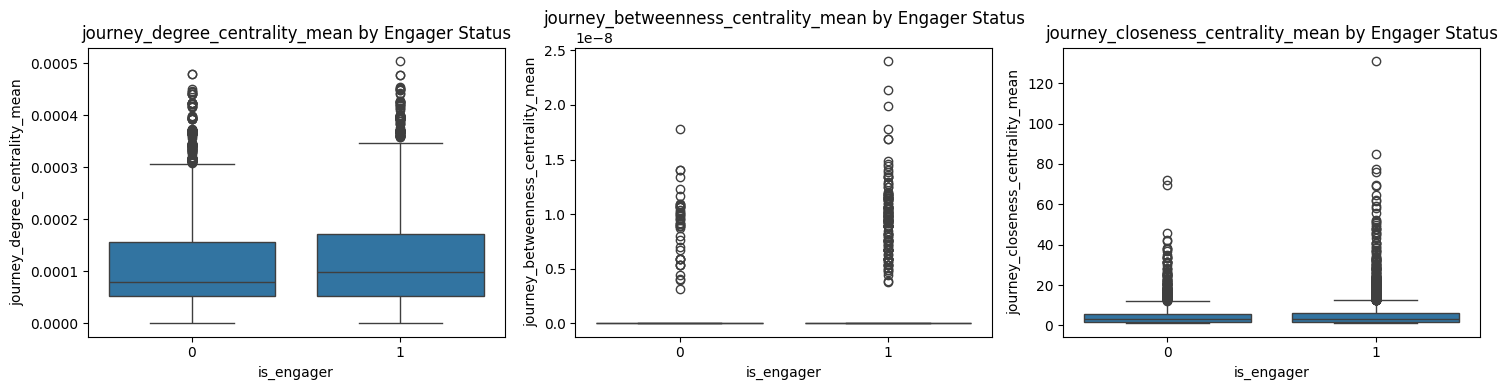

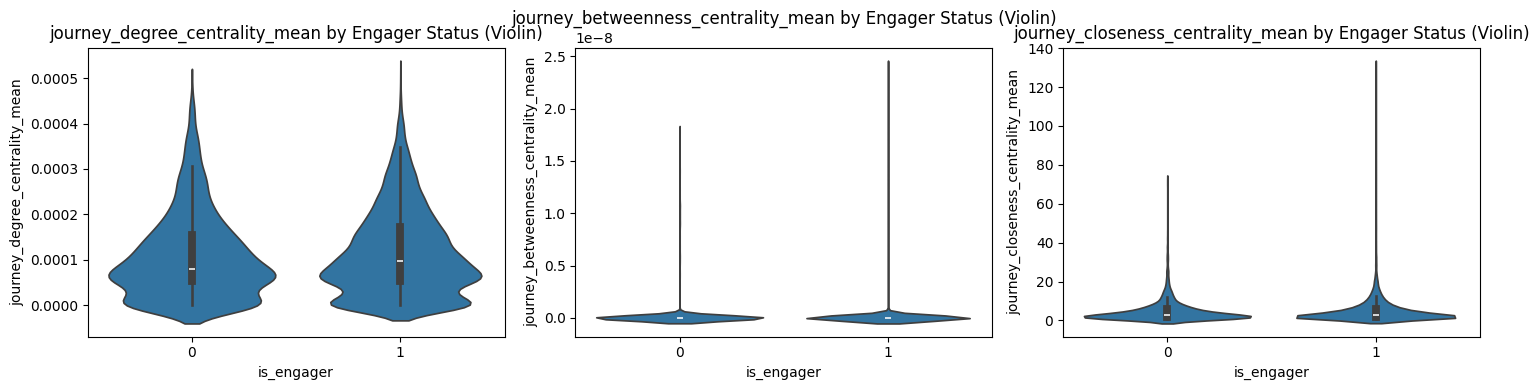

In [302]:
journey_centrality_engager_analysis(journey_df)

In [303]:
journey_df

,customer_id,receipt_id,total_price,total_quantity,avg_price,avg_quantity,median_price,median_quantity,std_price,std_quantity,...,journey_degree_centrality_median,journey_degree_centrality_std,journey_betweenness_centrality_mean,journey_betweenness_centrality_max,journey_betweenness_centrality_median,journey_betweenness_centrality_std,journey_closeness_centrality_mean,journey_closeness_centrality_max,journey_closeness_centrality_median,journey_closeness_centrality_std
0,779512,102580195,1.00,1.0,1.000000,1.000000,1.00,1.0,NaN,NaN,...,0.000000,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,779512,104503457,46.28,11.0,4.207273,1.000000,3.99,1.0,1.926573,0.000000,...,0.000160,0.000024,0.0,0.0,0.0,0.0,5.619980,6.857143,6.857143,1.403759
2,779512,105697326,17.44,8.0,2.180000,1.000000,2.34,1.0,1.288166,0.000000,...,0.000134,0.000026,0.0,0.0,0.0,0.0,2.166667,3.000000,1.666667,0.645497
3,779512,106131308,9.76,4.0,2.440000,1.000000,2.94,1.0,1.367479,0.000000,...,0.000080,0.000027,0.0,0.0,0.0,0.0,1.666667,2.000000,1.666667,0.333333
4,779512,107824442,75.89,23.0,3.299565,1.000000,2.09,1.0,4.638305,0.000000,...,0.000241,0.000020,0.0,0.0,0.0,0.0,7.109862,8.936170,7.088608,1.633142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8642,781856,118700466,5.89,1.0,5.890000,1.000000,5.89,1.0,NaN,NaN,...,0.000000,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
8643,781856,120474436,17.65,5.0,3.530000,1.000000,3.49,1.0,0.288097,0.000000,...,0.000107,0.000026,0.0,0.0,0.0,0.0,2.600000,3.000000,3.000000,0.489898
8644,781856,121683941,63.09,17.0,4.853077,1.307692,4.29,1.0,2.468743,0.480384,...,0.000214,0.000025,0.0,0.0,0.0,0.0,3.668529,4.965517,3.789474,1.000287
8645,781857,116553003,5.55,1.0,5.550000,1.000000,5.55,1.0,NaN,NaN,...,0.000000,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


c:\Users\tikib\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:28:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.36      0.43      0.39       485
           1       0.76      0.70      0.73      1245

    accuracy                           0.63      1730
   macro avg       0.56      0.57      0.56      1730
weighted avg       0.65      0.63      0.63      1730



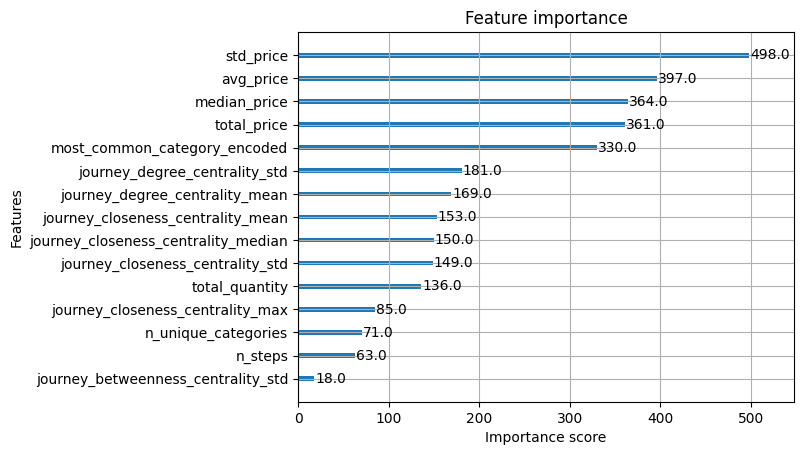

In [304]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import classification_report

# Encode most_common_category as integer
le = LabelEncoder()
journey_df['most_common_category_encoded'] = le.fit_transform(journey_df['most_common_category'])


# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
# centrality_cols = [
#     'journey_degree_centrality_mean', 'journey_degree_centrality_max', 'journey_degree_centrality_median', 'journey_degree_centrality_std',
#     'journey_betweenness_centrality_mean', 'journey_betweenness_centrality_max', 'journey_betweenness_centrality_median', 'journey_betweenness_centrality_std',
#     'journey_closeness_centrality_mean', 'journey_closeness_centrality_max', 'journey_closeness_centrality_median', 'journey_closeness_centrality_std'
# ]
# scaler = StandardScaler()
# centrality_scaled = scaler.fit_transform(journey_df[centrality_cols])
# kmeans = KMeans(n_clusters=100, random_state=42, n_init=10)
# journey_df['centrality_cluster'] = kmeans.fit_predict(centrality_scaled)

# Add 'centrality_cluster' to features
feature_cols = [
    'total_price', 'total_quantity', 'avg_price',
    'median_price', 'std_price',
    'n_unique_categories', 'n_steps', 'most_common_category_encoded',
    'journey_degree_centrality_mean', 'journey_degree_centrality_max', 'journey_degree_centrality_median', 'journey_degree_centrality_std',
    'journey_betweenness_centrality_mean', 'journey_betweenness_centrality_max', 'journey_betweenness_centrality_median', 'journey_betweenness_centrality_std',
    'journey_closeness_centrality_mean', 'journey_closeness_centrality_max', 'journey_closeness_centrality_median', 'journey_closeness_centrality_std',
    # 'centrality_cluster'
]

X = journey_df[feature_cols]
y = journey_df['is_engager']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature importance plot
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=15)
plt.show()